In [3]:
import numpy as np
import pandas as pd 
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [4]:
ff1.Cache.enable_cache('../cache')

In [5]:
year, event, event_type = 2023, 'Australia', 'R'
session = ff1.get_session(year, event, event_type)
laps = session.load_laps(with_telemetry=True)

C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)

In [46]:
driver_1, driver_2 = 'VER', 'HAM'
distance_min, distance_max = 3000, 4000

In [47]:
laps_driver_1 = laps.pick_driver(driver_1)
laps_driver_2 = laps.pick_driver(driver_2)

telemetry_driver_1 = laps_driver_1.pick_fastest().get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.pick_fastest().get_car_data().add_distance()

team_driver_1 = laps_driver_1.reset_index().loc[0, 'Team']
team_driver_2 = laps_driver_2.reset_index().loc[0, 'Team']

C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:378: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_slice.loc[:, 'Time'] = data_slice['SessionTime'] - start_time
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:378: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_slice.loc[:, 'Time'] = data_slice['SessionTime'] - start_time


In [48]:
telemetry_driver_1.loc[telemetry_driver_1['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_1.loc[telemetry_driver_1['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_1.loc[(telemetry_driver_1['Brake'] == 0) & (telemetry_driver_1['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

telemetry_driver_2.loc[telemetry_driver_2['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_2.loc[telemetry_driver_2['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_2.loc[(telemetry_driver_2['Brake'] == 0) & (telemetry_driver_2['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

In [49]:
telemetry_driver_1['ActionID'] = (telemetry_driver_1['CurrentAction'] != telemetry_driver_1['CurrentAction'].shift(1)).cumsum()
telemetry_driver_2['ActionID'] = (telemetry_driver_2['CurrentAction'] != telemetry_driver_2['CurrentAction'].shift(1)).cumsum()

In [50]:
actions_driver_1 = telemetry_driver_1[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()
actions_driver_2 = telemetry_driver_2[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()

actions_driver_1['Driver'] = driver_1
actions_driver_2['Driver'] = driver_2

In [51]:
actions_driver_1['DistanceDelta'] = actions_driver_1['Distance'] - actions_driver_1['Distance'].shift(1)
actions_driver_1.loc[0, 'DistanceDelta'] = actions_driver_1.loc[0, 'Distance']

actions_driver_2['DistanceDelta'] = actions_driver_2['Distance'] - actions_driver_2['Distance'].shift(1)
actions_driver_2.loc[0, 'DistanceDelta'] = actions_driver_2.loc[0, 'Distance']

In [52]:
all_actions = actions_driver_1.append(actions_driver_2)

C:\Users\Ricky\AppData\Local\Temp\ipykernel_27408\3193369198.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_actions = actions_driver_1.append(actions_driver_2)


In [53]:
avg_speed_driver_1 = np.mean(telemetry_driver_1['Speed'].loc[
    (telemetry_driver_1['Distance'] >= distance_min) & 
        (telemetry_driver_1['Distance'] <= distance_max) 
])


avg_speed_driver_2 = np.mean(telemetry_driver_2['Speed'].loc[
    (telemetry_driver_2['Distance'] >= distance_min) & 
        (telemetry_driver_2['Distance'] <= distance_max) 
])

if avg_speed_driver_1 > avg_speed_driver_2:    
    speed_text = f"{driver_1} {round(avg_speed_driver_1 - avg_speed_driver_2,2)}km/h faster"
else:
    speed_text = f"{driver_2} {round(avg_speed_driver_2 - avg_speed_driver_1,2)}km/h faster"


In [54]:
# Add a column for TimeDelta to the telemetry data
telemetry_driver_1['TimeDelta'] = telemetry_driver_1['Time'].diff().fillna(pd.Timedelta(seconds=0))
telemetry_driver_2['TimeDelta'] = telemetry_driver_2['Time'].diff().fillna(pd.Timedelta(seconds=0))

# Calculate total time of the telemetry data for each driver (convert to seconds)
total_time_driver_1 = telemetry_driver_1.iloc[-1]['Time'].total_seconds()
total_time_driver_2 = telemetry_driver_2.iloc[-1]['Time'].total_seconds()

# Calculate total time spent at full throttle for each driver (convert TimeDelta to seconds)
full_throttle_time_driver_1 = telemetry_driver_1.loc[telemetry_driver_1['CurrentAction'] == 'Full Throttle', 'TimeDelta'].sum().total_seconds()
full_throttle_time_driver_2 = telemetry_driver_2.loc[telemetry_driver_2['CurrentAction'] == 'Full Throttle', 'TimeDelta'].sum().total_seconds()

# Calculate the percentage of time spent at full throttle for each driver
full_throttle_percentage_driver_1 = (full_throttle_time_driver_1 / total_time_driver_1) * 100
full_throttle_percentage_driver_2 = (full_throttle_time_driver_2 / total_time_driver_2) * 100

In [55]:
plot_size = [13, 4]
autolayout = True
plot_title = f"{driver_1} Time Spent at Full Throttle: {full_throttle_percentage_driver_1: .2f}% \n {driver_2} Time Spent at Full Throttle: {full_throttle_percentage_driver_2: .2f}%"
plot_file = f"{session.event.year} {session.event.EventName}-{driver_1} VS {driver_2}-CornerAnalasys"
plot_ratios = [7,7]
plot_filename = plot_file.replace(" ", "") + ".png"

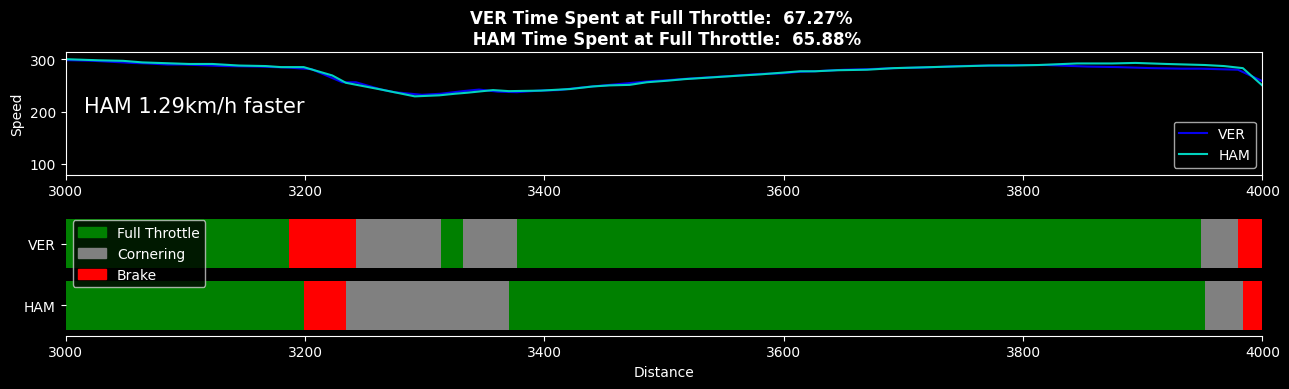

In [56]:
plt.rcParams['figure.figsize'] = plot_size
plt.rcParams['figure.autolayout'] = autolayout

telemetry_colors = {
    'Full Throttle': 'green',
    'Cornering': 'grey',
    'Brake': 'red',
}

fig, ax = plt.subplots(2)
ax[0].set_title(plot_title, fontweight='bold')
ax[0].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Speed'], label=driver_1, color=ff1.plotting.team_color(team_driver_1))
ax[0].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Speed'], label=driver_2, color=ff1.plotting.team_color(team_driver_2))

ax[0].text(distance_min+15, 200, speed_text, fontsize=15)

ax[0].set(ylabel='Speed')
ax[0].legend(loc='lower right')

for driver in [driver_1, driver_2]:
    driver_actions = all_actions.loc[all_actions['Driver'] == driver]
    
    previous_action_end = 0
    for _, action in driver_actions.iterrows():
        ax[1].barh(
            [driver],
            action['DistanceDelta'],
            left = previous_action_end,
            color = telemetry_colors[action['CurrentAction']]
        )
        
        previous_action_end = previous_action_end + action['DistanceDelta']
        
plt.xlabel('Distance')

plt.gca().invert_yaxis()

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

labels = list(telemetry_colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=telemetry_colors[label]) for label in labels]
ax[1].legend(handles, labels)

ax[0].set_xlim(distance_min, distance_max)
ax[1].set_xlim(distance_min, distance_max)

plt.style.use('dark_background')
plt.savefig(plot_filename, dpi=300)
plt.show()